## Введение

## Introduction

A dataset of various comments on the website of the Wikishop online store and their classification into negative and neutral/positive are given. Using machine learning, you need to automate checking comments for toxicity before sending them for moderation. The trained model must have an f1_score of at least 0.75

The work will be carried out in several stages: downloading, inspection and processing of data; exploratory data analysis; training and evaluation of models with tuning of hyperparameters on training and validation samples; final testing

## Preprocessing

In [1]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\albin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\albin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\albin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\albin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\albin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
import pandas as pd
import numpy as np

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import wordpunct_tokenize, word_tokenize
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

import plotly.express as px

In [3]:
try:
    data = pd.read_csv('toxic_comments.csv')
except:
    data = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
data.drop(columns='Unnamed: 0', inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [7]:
data.duplicated().sum()

0

In [8]:
data.isna().sum()

text     0
toxic    0
dtype: int64

In [9]:
text = data['text']

In [10]:
def replace(text):
    replacement = re.sub(r"\W\'" , ' ', text)
    replacement = re.sub(r'[^a-z\' ]', ' ', replacement.lower())
    replacement = ' '.join(replacement.split())
    return replacement

In [11]:
display(text[3])
replace(text[3])

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

"more i can't make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it's listed in the relevant form eg wikipedia good article nominations transport"

In [12]:
word_tokenize(replace(text[5]))

['congratulations',
 'from',
 'me',
 'as',
 'well',
 'use',
 'the',
 'tools',
 'well',
 'talk']

In [13]:
l = WordNetLemmatizer()

def lemmatize(text):
    lemma = [l.lemmatize(i) for i in text]
    return lemma

In [14]:
display(text[3])
display(replace(text[3]))
display(word_tokenize(replace(text[3])))
display(lemmatize(word_tokenize(replace(text[3]))))
display(' '.join(lemmatize(word_tokenize(replace(text[3])))))

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

"more i can't make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it's listed in the relevant form eg wikipedia good article nominations transport"

['more',
 'i',
 'ca',
 "n't",
 'make',
 'any',
 'real',
 'suggestions',
 'on',
 'improvement',
 'i',
 'wondered',
 'if',
 'the',
 'section',
 'statistics',
 'should',
 'be',
 'later',
 'on',
 'or',
 'a',
 'subsection',
 'of',
 'types',
 'of',
 'accidents',
 'i',
 'think',
 'the',
 'references',
 'may',
 'need',
 'tidying',
 'so',
 'that',
 'they',
 'are',
 'all',
 'in',
 'the',
 'exact',
 'same',
 'format',
 'ie',
 'date',
 'format',
 'etc',
 'i',
 'can',
 'do',
 'that',
 'later',
 'on',
 'if',
 'no',
 'one',
 'else',
 'does',
 'first',
 'if',
 'you',
 'have',
 'any',
 'preferences',
 'for',
 'formatting',
 'style',
 'on',
 'references',
 'or',
 'want',
 'to',
 'do',
 'it',
 'yourself',
 'please',
 'let',
 'me',
 'know',
 'there',
 'appears',
 'to',
 'be',
 'a',
 'backlog',
 'on',
 'articles',
 'for',
 'review',
 'so',
 'i',
 'guess',
 'there',
 'may',
 'be',
 'a',
 'delay',
 'until',
 'a',
 'reviewer',
 'turns',
 'up',
 'it',
 "'s",
 'listed',
 'in',
 'the',
 'relevant',
 'form',
 'eg

['more',
 'i',
 'ca',
 "n't",
 'make',
 'any',
 'real',
 'suggestion',
 'on',
 'improvement',
 'i',
 'wondered',
 'if',
 'the',
 'section',
 'statistic',
 'should',
 'be',
 'later',
 'on',
 'or',
 'a',
 'subsection',
 'of',
 'type',
 'of',
 'accident',
 'i',
 'think',
 'the',
 'reference',
 'may',
 'need',
 'tidying',
 'so',
 'that',
 'they',
 'are',
 'all',
 'in',
 'the',
 'exact',
 'same',
 'format',
 'ie',
 'date',
 'format',
 'etc',
 'i',
 'can',
 'do',
 'that',
 'later',
 'on',
 'if',
 'no',
 'one',
 'else',
 'doe',
 'first',
 'if',
 'you',
 'have',
 'any',
 'preference',
 'for',
 'formatting',
 'style',
 'on',
 'reference',
 'or',
 'want',
 'to',
 'do',
 'it',
 'yourself',
 'please',
 'let',
 'me',
 'know',
 'there',
 'appears',
 'to',
 'be',
 'a',
 'backlog',
 'on',
 'article',
 'for',
 'review',
 'so',
 'i',
 'guess',
 'there',
 'may',
 'be',
 'a',
 'delay',
 'until',
 'a',
 'reviewer',
 'turn',
 'up',
 'it',
 "'s",
 'listed',
 'in',
 'the',
 'relevant',
 'form',
 'eg',
 'wikip

"more i ca n't make any real suggestion on improvement i wondered if the section statistic should be later on or a subsection of type of accident i think the reference may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else doe first if you have any preference for formatting style on reference or want to do it yourself please let me know there appears to be a backlog on article for review so i guess there may be a delay until a reviewer turn up it 's listed in the relevant form eg wikipedia good article nomination transport"

In [15]:
"I ca n't do it".replace("ca n't", "can't")

"I can't do it"

In [16]:
def clean(text):
    text = replace(text)
    tokens = wordpunct_tokenize(text)
    lemma = lemmatize(tokens)
    lemma = ' '.join(lemma)
    lemma = lemma.replace(" n't", "n't")
    lemma = lemma.replace("' ", "'")
    lemma = lemma.replace(" '", "'")
    return lemma

In [17]:
' '.join(lemmatize(wordpunct_tokenize(replace(text[15]))))

"juelz santanas age in juelz santana wa year old then came february th which make juelz turn making song with the diplomat the third neff to be signed to cam ' s label under roc a fella in he wa year old coming out with his own single santana ' s town and down so yes he is born in he really is how could he be older then lloyd bank and how could he be when his birthday passed the homie neff is year old juelz death god forbid if your thinking about that equal go to your caculator and stop changing his year of birth my god"

In [18]:
data['cleaned'] = data['text'].apply(clean)
data.head()

,text,toxic,cleaned
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d'aww he match this background colour i'm seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i'm really not trying to edit war it's...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can't make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


In [19]:
del text

**Description of data preprocessing:**

The data was processed as follows: words were reduced to lower case, all characters except letters, apostrophes and spaces were removed; texts were tokenized and lemmatized word by word. There are no duplicates or missing values

## Exploratory data analysis

In [20]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from collections import Counter
import seaborn as sns

In [21]:
all_words = " ".join([text for text in data['cleaned']]) 
toxic = " ".join([text for text in data.loc[data['toxic']==1, 'cleaned']])
neutral = " ".join([text for text in data.loc[data['toxic']==0, 'cleaned']])

In [22]:
stopwords = set(stopwords.words('english'))

Most common words in a typical comment


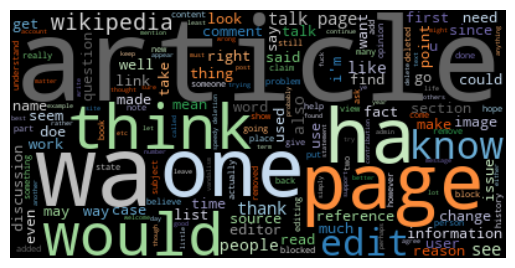

Most common words in a toxic comment


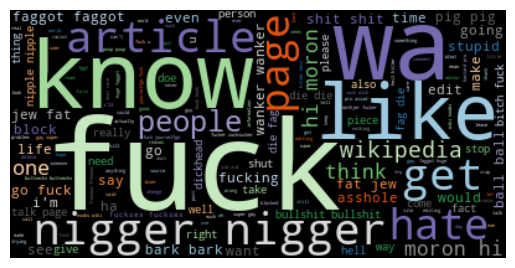

Most common words in a non-toxic comment


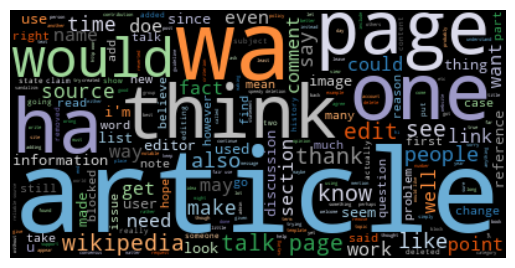

In [23]:
wc = WordCloud(random_state=12345, colormap='tab20c', stopwords=stopwords, max_font_size=100)

print('Most common words in a typical comment')
wordcloud = wc.generate(all_words) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

print('Most common words in a toxic comment')
wordcloud = wc.generate(toxic) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

print('Most common words in a non-toxic comment')
wordcloud = wc.generate(neutral) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

In [24]:
unique = Counter(all_words.split())
unique_df = pd.DataFrame.from_dict(unique, orient='index', columns=['count'])

unique_toxic = Counter(toxic.split())
unique_toxic_df = pd.DataFrame.from_dict(unique_toxic, orient='index', columns=['count'])

unique_neutral = Counter(neutral.split())
unique_neutral_df = pd.DataFrame.from_dict(unique_neutral, orient='index', columns=['count'])

The number of unique words in toxic and neutral comments is shown below

In [25]:
display(unique_df['count'].describe())
display(unique_toxic_df['count'].describe())
display(unique_neutral_df['count'].describe())
print(unique_df['count'].sum(axis=0))

count    177851.000000
mean         59.886619
std        2179.740084
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max      495550.000000
Name: count, dtype: float64

count    32297.000000
mean        26.542713
std        409.306987
min          1.000000
25%          1.000000
50%          1.000000
75%          4.000000
max      38225.000000
Name: count, dtype: float64

count    169091.000000
mean         57.919375
std        2079.446216
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max      472522.000000
Name: count, dtype: float64

10650895


In [26]:
toxic_index = list(set(unique_toxic_df.index) - set(unique_neutral_df.index))
len(toxic_index)

8760

In [27]:
unique_toxic_df.iloc[unique_toxic_df.index.isin(toxic_index)].sum(axis=0)

count    24233
dtype: int64

The use of exclamation marks is more common in toxic comments

In [28]:
def exclamation_count(string):
    l = [i for i in string if i=="!"]
    return len(l)

exclamation_count("I'm! gonna swing! from the chandelier!")

3

In [29]:
data['text'].apply(exclamation_count).describe()

count    159292.000000
mean          0.661653
std          25.921868
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4942.000000
Name: text, dtype: float64

In [30]:
data.loc[data['toxic']==1, 'text'].apply(exclamation_count).describe()

count    16186.000000
mean         3.474669
std         75.081067
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       4942.000000
Name: text, dtype: float64

In [31]:
data.loc[data['toxic']==0, 'text'].apply(exclamation_count).describe()

count    143106.000000
mean          0.343487
std          10.459017
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        2762.000000
Name: text, dtype: float64

Target feature is unbalanced

In [32]:
data['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

Using the pronoun “you” depending on the emotional tone of the comment

In [33]:
print('Relative frequency of use of the 2nd person pronoun in a typical commentary:', 
      round(unique_df.loc['you', 'count'] / unique_df['count'].sum(axis=0), 3))

print('Relative frequency of use of the 2nd person pronoun in a toxic commentary:',
      round(unique_toxic_df.loc['you', 'count'] / unique_toxic_df['count'].sum(axis=0), 3))

print('Relative frequency of use of the 2nd person pronoun in a neutral commentary:', 
      round(unique_neutral_df.loc['you', 'count'] / unique_neutral_df['count'].sum(axis=0), 3))

Relative frequency of use of the 2nd person pronoun in a typical commentary: 0.019
Relative frequency of use of the 2nd person pronoun in a toxic commentary: 0.045
Relative frequency of use of the 2nd person pronoun in a neutral commentary: 0.017


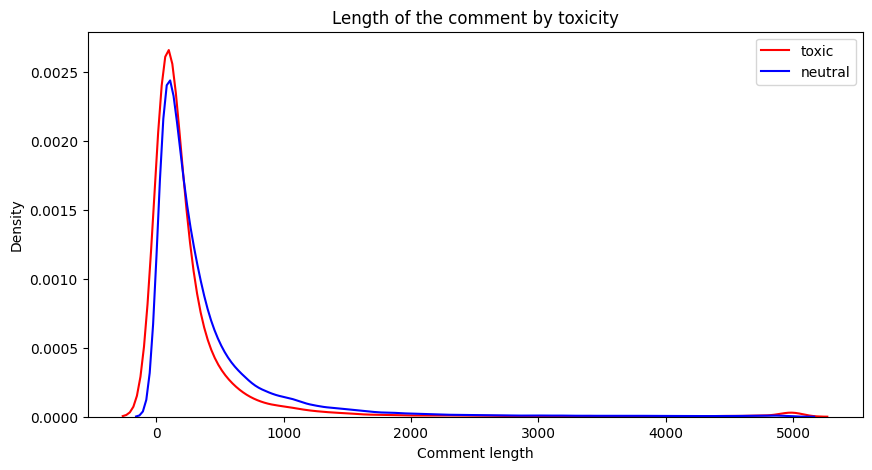

In [34]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data.query('toxic == 1')['text'].apply(len), color='red')
sns.kdeplot(data.query('toxic == 0')['text'].apply(len), color='blue')
plt.title('Length of the comment by toxicity')
plt.legend(['toxic', 'neutral'])
plt.xlabel('Comment length')
plt.show()

**Description of exploratory analysis:**

Words typical of toxic and non-toxic comments are illustrated using a word cloud at the beginning of this step.

In total there are over 10,000,000 words, of which about 177,000 words are unique.

Some words are unique to and commonly used in toxic comments. There are over 8,000 such words in the dataset and in total they were used more than 24,000 times. Toxic comments often contain exclamation points. The pronoun "you" is used 2.5 times more often in negative comments. (Perhaps, neutral comments use "I-statements" more often and do not, unlike toxic comments, use ad hominem attacks involving pronoun "you")

The classes are unbalanced: neutral comments 90% of the sample, toxic - 10%

## Model training

In [35]:
features_train, features_valid, target_train, target_valid = train_test_split(data['cleaned'], 
                                                                              data['toxic'], 
                                                                              random_state=12345,
                                                                              test_size=0.4,
                                                                              stratify=data['toxic'])
features_valid, features_test, target_valid, target_test = train_test_split(data['cleaned'], 
                                                                              data['toxic'], 
                                                                              random_state=12345,
                                                                              test_size=0.5,
                                                                              stratify=data['toxic'])

In [36]:
tf = TfidfVectorizer(stop_words=stopwords, min_df=50)

X_train = tf.fit_transform(features_train)
X_valid = tf.transform(features_valid)
X_test = tf.transform(features_test)

In [37]:
X_train.shape

(95575, 5245)

In [38]:
forest = None
score = 0

for est in [35, 70]:
    for samples in [2, 5]:
            
        forest_0 = RandomForestClassifier(random_state=12345, 
                                          n_estimators=est, 
                                          max_depth=60, 
                                          min_samples_leaf=samples,
                                          max_features='sqrt',
                                          class_weight='balanced')
        forest_0.fit(X_train, target_train)
        score_0 = f1_score(target_valid, forest_0.predict(X_valid))
        
        if score_0 > score:
            score = score_0
            forest = forest_0

print(score)

0.6880907372400757


In [39]:
forest

RandomForestClassifier(class_weight='balanced', max_depth=60,
                       max_features='sqrt', min_samples_leaf=2, n_estimators=70,
                       random_state=12345)

In [40]:
logreg = None
score = 0

for solver in ['liblinear']:
    for penalty in ['l1', 'l2']:
        for c in [10, 1, 0.1, 0.01]:
            try:
                logreg_0 = LogisticRegression(random_state=12345, 
                                              solver=solver, 
                                              class_weight = {0:4, 1:6},
                                              penalty=penalty,
                                              C=c,
                                              max_iter=200)
                logreg_0.fit(X_train, target_train)
                score_0 = f1_score(target_valid, logreg_0.predict(X_valid))
        
                if score_0 > score:
                    score = score_0
                    logreg = logreg_0
            except:
                pass

print(score)

0.8456238836437867


In [41]:
logreg

LogisticRegression(C=10, class_weight={0: 4, 1: 6}, max_iter=200, penalty='l1',
                   random_state=12345, solver='liblinear')

In [42]:
def feval_func(preds, train_data):
    labels = train_data.get_label()
    preds = np.round(preds)
    eval_result = f1_score(labels, preds)
    return 'f1_score', eval_result, True

In [43]:
train = lgb.Dataset(X_train, target_train)
valid = lgb.Dataset(X_valid, target_valid, reference=train)

In [44]:
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': None,
    'learning_rate': 0.4,
    'num_leaves': 20,
    'scale_pos_weight': 2.25,
    'feature_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 15,
    'verbose': -1
}

gbdt = lgb.train(params,
                 train_set=train,
                 valid_sets=valid,
                 feval=feval_func)

[1]	valid_0's binary_logloss: 0.252802	valid_0's f1_score: 0.554306
[2]	valid_0's binary_logloss: 0.223484	valid_0's f1_score: 0.636024
[3]	valid_0's binary_logloss: 0.210169	valid_0's f1_score: 0.656842
[4]	valid_0's binary_logloss: 0.201374	valid_0's f1_score: 0.688369
[5]	valid_0's binary_logloss: 0.193108	valid_0's f1_score: 0.701886
[6]	valid_0's binary_logloss: 0.187661	valid_0's f1_score: 0.709268
[7]	valid_0's binary_logloss: 0.183093	valid_0's f1_score: 0.718556
[8]	valid_0's binary_logloss: 0.17931	valid_0's f1_score: 0.721182
[9]	valid_0's binary_logloss: 0.174951	valid_0's f1_score: 0.727597
[10]	valid_0's binary_logloss: 0.171576	valid_0's f1_score: 0.734289
[11]	valid_0's binary_logloss: 0.168089	valid_0's f1_score: 0.743961
[12]	valid_0's binary_logloss: 0.165113	valid_0's f1_score: 0.748465
[13]	valid_0's binary_logloss: 0.162463	valid_0's f1_score: 0.753202
[14]	valid_0's binary_logloss: 0.159678	valid_0's f1_score: 0.758564
[15]	valid_0's binary_logloss: 0.157434	vali

In [45]:
params = {
    'task': 'train', 
    'boosting': 'goss',
    'objective': 'binary',
    'metric': None,
    'learning_rate': 0.5,
    'num_leaves': 30,
    'scale_pos_weight': 2,
    'bagging_freq': 5,
    'feature_fraction': 0.8,
    'max_depth': 10,
    'verbose': -1
}

goss = lgb.train(params,
                 train_set=train,
                 valid_sets=valid,
                 feval=feval_func)

[1]	valid_0's binary_logloss: 0.257704	valid_0's f1_score: 0.520279
[2]	valid_0's binary_logloss: 0.219951	valid_0's f1_score: 0.666818
[3]	valid_0's binary_logloss: 0.205476	valid_0's f1_score: 0.692787
[4]	valid_0's binary_logloss: 0.194971	valid_0's f1_score: 0.705602
[5]	valid_0's binary_logloss: 0.185488	valid_0's f1_score: 0.716544
[6]	valid_0's binary_logloss: 0.17848	valid_0's f1_score: 0.727221
[7]	valid_0's binary_logloss: 0.173073	valid_0's f1_score: 0.735815
[8]	valid_0's binary_logloss: 0.168221	valid_0's f1_score: 0.742311
[9]	valid_0's binary_logloss: 0.164203	valid_0's f1_score: 0.747625
[10]	valid_0's binary_logloss: 0.160865	valid_0's f1_score: 0.750121
[11]	valid_0's binary_logloss: 0.157978	valid_0's f1_score: 0.75336
[12]	valid_0's binary_logloss: 0.154533	valid_0's f1_score: 0.75948
[13]	valid_0's binary_logloss: 0.151837	valid_0's f1_score: 0.763021
[14]	valid_0's binary_logloss: 0.148994	valid_0's f1_score: 0.767507
[15]	valid_0's binary_logloss: 0.146641	valid_

In [46]:
goss.params

{'task': 'train',
 'boosting': 'goss',
 'objective': 'binary',
 'metric': None,
 'learning_rate': 0.5,
 'num_leaves': 30,
 'scale_pos_weight': 2,
 'bagging_freq': 5,
 'feature_fraction': 0.8,
 'max_depth': 10,
 'verbose': -1,
 'num_iterations': 100,
 'early_stopping_round': None}

**Training description:**

Using the TF-IDF vectorizer, features for training models were obtained from this processed text. Three classification models were trained and validated on random training and validation data. The random forest model scored the worst, its f1-score is less than 0.75. The logistic regression model showed a result of 85% after tuning the hyperparameters. LightGBM models were also trained. The boosting model with the parameters described above gave an f1-score of 0.86 on the validation data. It was more successful than all the others, so it makes sense to select this model for further testing. To prevent overfitting, some hyperparameters were added: 'bagging_freq', 'num_leaves' and others.

## Testing

In [47]:
predictions = goss.predict(X_test)
predictions = np.round(predictions)

In [48]:
f1_score(target_test, predictions)

0.7789180957425675

In [57]:
fig = px.imshow(confusion_matrix(target_test, predictions), 
                x=["Predicted 0", "Predicted 1"], y=["True 0", "True 1"], text_auto=True,
                title='Confusion matrix', 
               )
fig.show()

**Output:**

The resulting model is overfitted. However, it copes with the task, its test f1-score is indeed higher than 0.75